# Investigating the feasibility of building a model to predict terminal category membership

Created by: Grace Patlewicz<br>
Date: 13 May 2024<br>
This notebook investigates the potential of building a ML model to predict terminal category membership in lieu of having to recluster each time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'

In [3]:
import sys

In [4]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [5]:
from model_functions import *

In [6]:
df = pd.read_excel(interim_dir+'final_revised_universe_wmappingdict_130524.xlsx', index_col = [0])

In [7]:
from sklearn.model_selection import cross_validate,KFold,ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display = 'diagram')

In [8]:
data = mk_fp(df)

In [9]:
data.shape

(15525, 1024)

In [10]:
data.head()

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1014,mrgn_1015,mrgn_1016,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023
IROQAHVXXUQBOS-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
DTXSID90897582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID90896257,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
DTXSID90896196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
DTXSID90896095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
df['group_str']=[str(e) for e in df['group'] ]

In [13]:
df1 = df.set_index('dtxsid')
y = df1['group_str']

In [14]:
df2 = pd.concat([data, y], axis = 1)

In [15]:
df2 = df2.sample(frac = 1)

In [17]:
df2.head()

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1015,mrgn_1016,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023,group_str
DTXSID00895559,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"('n:2 fluorotelomer-based substances', 'gte7',..."
OLICQSHPIGHELV-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"('Si PFASs', 'lt7', nan, nan)"
SDIMKWZEFIQIRV-UHFFFAOYSA-N,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"('PolyFCA derivatives', 'lt7', 4.0, 1.0)"
DTXSID501335657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"('Other PFASs, cyclic', 'lt7', 1.0, 2.0)"
DTXSID601353387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"('others', 'lt7', 3.0, 1.0)"


In [18]:
from collections import Counter

In [19]:
df2['group_str'].value_counts()

('Aromatic PFASs', 'lt7', 2.0, 5.0)            1238
('PASF-based substances', 'gte7', nan, nan)     770
('PASF-based substances', 'lt7', nan, nan)      697
('Aromatic PFASs', 'lt7', 2.0, 2.0)             592
('Aromatic PFASs', 'gte7', nan, nan)            584
                                               ... 
('Other PFASs, cyclic', 'gte7', 2.0, nan)         4
('unclassified', 'lt7', 2.0, 2.0)                 2
('Other PFASs, cyclic', 'gte7', 1.0, nan)         2
('Other PFASs, cyclic', 'gte7', 3.0, nan)         2
('PFAAs, cyclic', 'gte7', nan, nan)               1
Name: group_str, Length: 128, dtype: int64

In [20]:
counts = Counter([molecule for molecule in df2['group_str']])

In [21]:
len( [group for group in counts if counts[group]>=10])

117

In [22]:
small_groups = [group for group in counts if counts[group]<10]

In [23]:
len(small_groups)

11

In [24]:
df2['group'] = df2['group_str'].apply(lambda x: 'misc_category' if x in small_groups else x)

In [25]:
#df2.group.value_counts().reset_index()[df2.group.value_counts().reset_index()['group'] <50]

In [26]:
cats = set(df2['group'].sort_values().tolist())

In [27]:
my_dict = {}
sorted_cats = sorted(cats)  # Sort the categories

for i, e in enumerate(sorted_cats, 1):
    a = f'Category{i}'
    my_dict[e] = a
    

In [28]:
#my_dict

In [29]:
df2['category'] = df2['group'].replace(my_dict)

In [30]:
df2.category.value_counts()

Category7      1238
Category30      770
Category31      697
Category4       592
Category1       584
               ... 
Category61       12
Category81       11
Category115      11
Category104      10
Category102      10
Name: category, Length: 118, dtype: int64

In [31]:
y = df2['category']

In [32]:
X = df2.drop(['group_str', 'group', 'category'], axis = 1)

In [33]:
X.shape

(15525, 1024)

In [34]:
y

DTXSID00895559                  Category88
OLICQSHPIGHELV-UHFFFAOYSA-N     Category87
SDIMKWZEFIQIRV-UHFFFAOYSA-N     Category66
DTXSID501335657                Category118
DTXSID601353387                 Category95
                                  ...     
DTXSID5059799                   Category62
DTXSID701023228                 Category64
DTXSID001034345                 Category90
DTXSID30896372                   Category7
DTXSID60380370                  Category18
Name: category, Length: 15525, dtype: object

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

In [36]:
from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0)

In [37]:
var_thr.fit(X_train)

VarianceThreshold(threshold=0)

In [38]:
concol = [col for col in X_train.columns if col not in X_train.columns[var_thr.get_support()]]

In [39]:
len(concol)

1

In [41]:
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

In [42]:
scorer = make_scorer(balanced_accuracy_score)

In [43]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [44]:
result_dummy = cross_validate(dummy_clf, X_train, y_train, cv=cv, scoring = scorer )

In [45]:
result_dummy

{'fit_time': array([0.18855143, 0.06267715, 0.07602406, 0.06354666, 0.08041596]),
 'score_time': array([0.00910258, 0.00875807, 0.00852156, 0.0086534 , 0.00782108]),
 'test_score': array([0.00847458, 0.00847458, 0.00847458, 0.00847458, 0.00847458])}

In [46]:
rfc = RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42)

In [47]:
cv_results = cross_validate(rfc, X_train, y_train , cv=cv, scoring = scorer, return_train_score = True)

In [48]:
cv_results

{'fit_time': array([6.44576001, 6.48295403, 6.33795929, 6.29506421, 6.57434177]),
 'score_time': array([0.25418711, 0.22251606, 0.22290015, 0.17649913, 0.30175352]),
 'test_score': array([0.70398394, 0.71214114, 0.71041498, 0.70830571, 0.70096928]),
 'train_score': array([0.99069719, 0.99179254, 0.99149103, 0.99227368, 0.99172165])}

In [49]:
cv_results['test_score'].mean()

0.7071630096962741

In [50]:
print(' 5 fold CV mean BA score = {} with 10 fold CV std = {}'.format(cv_results['test_score'].mean(), cv_results['test_score'].std()))


 5 fold CV mean BA score = 0.7071630096962741 with 10 fold CV std = 0.004126297904755638


In [51]:
cv_results = pd.DataFrame(cv_results)

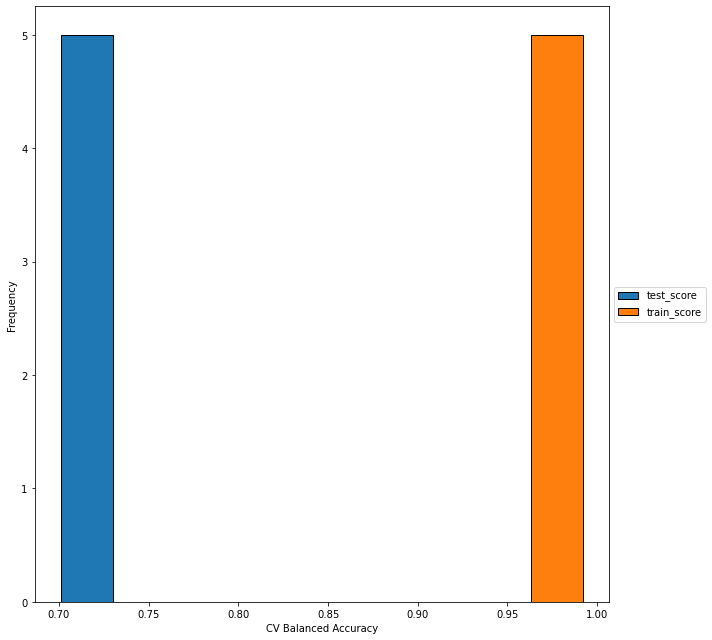

In [52]:
cv_results[['test_score', 'train_score']].plot.hist(edgecolor = 'black', figsize = (10,9))
plt.xlabel('CV Balanced Accuracy')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.tight_layout()

In [53]:
from sklearn.model_selection import validation_curve
rf = RandomForestClassifier(max_samples = 0.66, random_state = 42)
n_estimators = [1,5, 10, 25, 50, 75, 100, 150]
train_scores, test_scores = validation_curve(
    rf, X_train, y_train, param_name="n_estimators", param_range=n_estimators,
    cv=cv, scoring=scorer, n_jobs=2)

/home/gpatlewi/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0, 0.5, 'Balanced Accuracy (mean)')

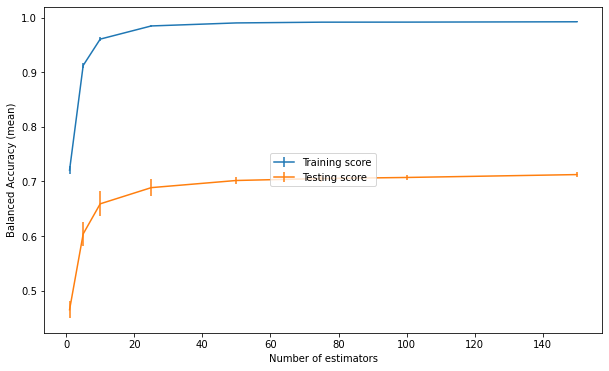

In [54]:
plt.figure(figsize = (10,6))
plt.errorbar(n_estimators, train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1), label='Training score')
plt.errorbar(n_estimators, test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1), label='Testing score')
plt.legend(loc = 'center')

plt.xlabel("Number of estimators")
plt.ylabel("Balanced Accuracy (mean)")

In [55]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [60]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced','balanced_subsample', None],
    'criterion' :['gini', 'entropy'],
    'max_samples' : [0.66]
    
}

In [61]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [62]:
rf_classifier = RandomForestClassifier(random_state = 42, )

In [64]:
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=50,
                                   scoring=make_scorer(balanced_accuracy_score), n_jobs=-1, cv=inner_cv, random_state=42)

# Fit the random search to your data
cv_random_search = cross_validate(random_search, X_train, y_train , cv=outer_cv, scoring = scorer, return_estimator = True)


# Get the best parameters and best estimator


/home/gpatlewi/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gpatlewi/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gpatlewi/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/gpatlewi/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker ti

In [65]:
for estimator in cv_random_search["estimator"]:
    print(estimator.best_params_, estimator.best_score_)

{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.66, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced_subsample'} 0.7354828390354633
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.66, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced_subsample'} 0.735335828023033
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.66, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced_subsample'} 0.7416440929051038
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.66, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'class_weight': 'balanced_subsample'} 0.7338456943688542
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.66, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'cl

In [66]:
cv_random_search['test_score'].mean(), cv_random_search['test_score'].std()

(0.7521400437565504, 0.005270951832050377)

In [67]:
model = RandomForestClassifier(random_state = 42, n_estimators= 400,
 min_samples_split=2,
 min_samples_leaf= 2,
 max_features='sqrt',
max_samples=0.66,
 max_depth= None,
 criterion='gini',
 class_weight= 'balanced_subsample')

In [68]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_samples=0.66,
                       min_samples_leaf=2, n_estimators=400, random_state=42)

In [69]:
preds = model.predict(X_test)

In [70]:
balanced_accuracy_score(y_test, preds)

0.7870361631448282

In [71]:
from sklearn.metrics import recall_score, accuracy_score
unique_classes = set(y_test)

# Initialize a dictionary to store the balanced accuracy scores for each class
balanced_accuracy_scores = {}
recall_scores = {}
# Compute balanced accuracy for each class
for cls in unique_classes:
    # Create binary labels for the current class
    y_true_cls = [1 if y == cls else 0 for y in y_test]
    y_pred_cls = [1 if y == cls else 0 for y in preds]
    
    # Compute recall (sensitivity) for the current class
    recall = recall_score(y_true_cls, y_pred_cls)
    
    # Compute specificity (true negative rate) for the current class
    tn = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == pred == 0)
    fp = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == 0 and pred == 1)
    specificity = tn / (tn + fp)
    
    # Compute balanced accuracy for the current class
    balanced_accuracy = (recall + specificity) / 2
    
    # Store the balanced accuracy score for the current class
    balanced_accuracy_scores[cls] = balanced_accuracy
    recall_scores [cls] = recall


In [72]:
recall_scores['Category1']

0.9145299145299145

In [73]:
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.metrics import confusion_matrix, classification_report


In [74]:
matthews_corrcoef(y_test, preds)

0.816037885208983

In [75]:
confusion_matrix(y_test, preds)

array([[107,   2,   0, ...,   0,   0,   0],
       [  0,  36,   0, ...,   0,   0,   0],
       [  0,   0,   7, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  24,   0,   0],
       [  1,   0,   0, ...,   0,   2,   2],
       [  0,   0,   0, ...,   0,   0,   2]])

In [76]:
report = (classification_report(y_test, preds))

/home/gpatlewi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gpatlewi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gpatlewi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [77]:
report = report.split('\n')

In [78]:
test = pd.DataFrame(report)

In [79]:
test

,0
0,precision recall f1-score ...
1,
2,Category1 0.93 0.91 0.92 ...
3,Category10 0.90 0.90 0.90 ...
4,Category100 0.88 0.58 0.70 ...
...,...
120,
121,accuracy 0.82 ...
122,macro avg 0.76 0.79 0.75 ...
123,weighted avg 0.84 0.82 0.82 ...


In [80]:
result_df = test[0].str.split(expand=True)

In [81]:
 result_df.iloc[0,:].tolist()

['precision', 'recall', 'f1-score', 'support', None, None]

In [83]:
result_df.columns = ['Category', 'precision', 'recall', 'f1-score', 'support', 'untitled',]

In [84]:
result_df.to_csv(external_dir+'cr_mgrn.csv')

In [87]:
report_df = pd.read_csv(external_dir+'cr_mgrn.csv', index_col = [0])

In [88]:
report_df

,Category,precision,recall,f1-score,support
2,Category1,0.93,0.91,0.92,117
3,Category10,0.90,0.90,0.90,40
4,Category100,0.88,0.58,0.70,12
5,Category101,0.83,0.50,0.62,20
6,Category102,0.67,1.00,0.80,2
...,...,...,...,...,...
118,Category98,0.33,0.40,0.36,5
119,Category99,0.50,1.00,0.67,2
121,accuracy,NaN,NaN,0.82,3105
122,macro_avg,0.76,0.79,0.75,3105


In [89]:
reverse_dict = {v:k for k,v in my_dict.items()}

In [90]:
report_df['terminal_category'] = report_df['Category'].replace(reverse_dict)

In [91]:
report_df =  pd.merge(report_df, pd.DataFrame(list(balanced_accuracy_scores.items()), columns = ['Category', 'BA']), on = 'Category', how = 'left' )

In [92]:
report_df.sort_values(by = 'BA', ascending = False).head(10)

,Category,precision,recall,f1-score,support,terminal_category,BA
107,Category9,1.00,1.0,1.0,12,"('Aromatic PFASs', 'lt7', 4.0, 1.0)",1.000000
63,Category5,1.00,1.0,1.0,18,"('Aromatic PFASs', 'lt7', 2.0, 3.0)",1.000000
6,Category104,1.00,1.0,1.0,2,"('others, cyclic', 'lt7', 2.0, 3.0)",1.000000
101,Category84,1.00,1.0,1.0,4,"('Polyfluoroalkyl acids, cyclic', 'lt7', 5.0, ...",1.000000
99,Category82,1.00,1.0,1.0,2,"('Polyfluoroalkyl acids, cyclic', 'lt7', 4.0, ...",1.000000
73,Category59,1.00,1.0,1.0,7,"('PFAAs, cyclic', 'lt7', 1.0, nan)",1.000000
98,Category81,1.00,1.0,1.0,2,"('Polyfluoroalkyl acids, cyclic', 'lt7', 3.0, ...",1.000000
97,Category80,1.00,1.0,1.0,5,"('Polyfluoroalkyl acids, cyclic', 'lt7', 2.0, ...",1.000000
75,Category60,1.00,1.0,1.0,3,"('PFAAs, cyclic', 'lt7', 2.0, nan)",1.000000
4,Category102,0.67,1.0,0.8,2,"('others, cyclic', 'lt7', 2.0, 1.0)",0.999839


In [93]:
report_df.to_csv(external_dir+'classification_performance_mgrn_140524.csv')

In [94]:
report_df1 = report_df.iloc[:118,:].melt(id_vars=['terminal_category'], value_vars=['recall','BA'], var_name='metric', value_name='value')

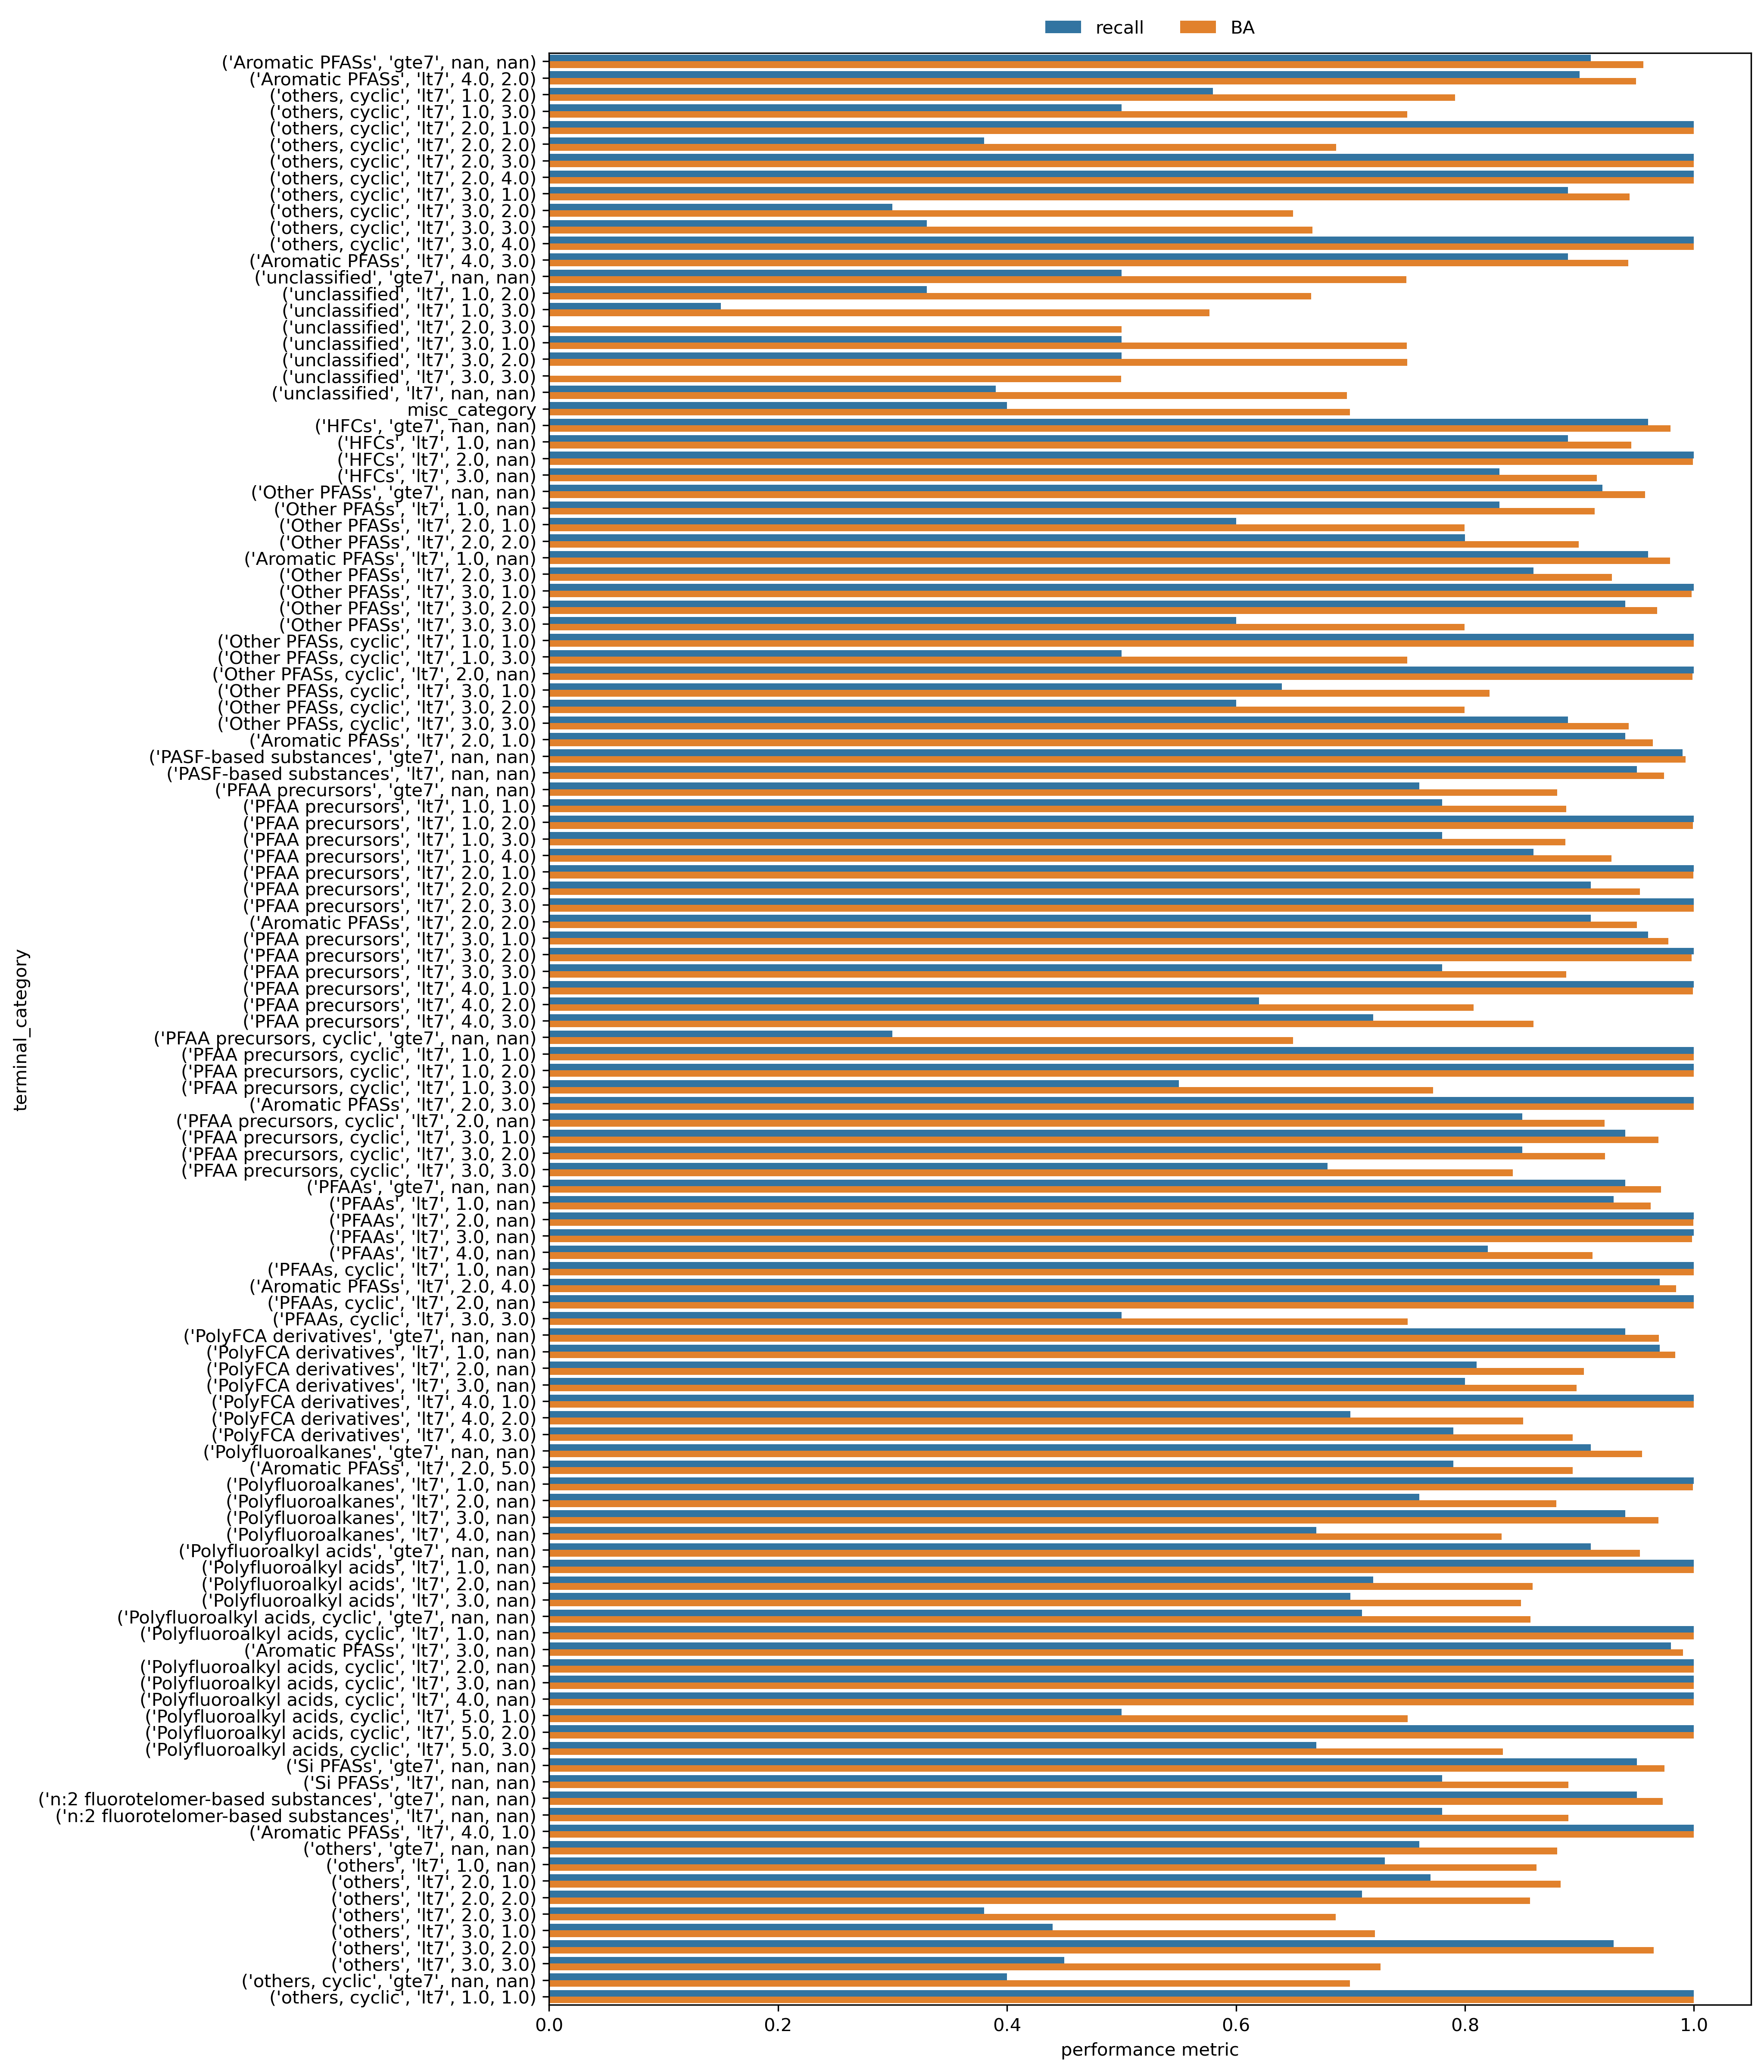

In [95]:
fig,ax = plt.subplots(figsize=(12, 20), dpi=300)
p = sns.barplot(ax=ax, data=report_df1, y='terminal_category', x='value', hue='metric', orient='h')
sns.move_legend(ax, "lower center",bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False, fontsize=10 )
ax.set_xlabel('performance metric')
fig.savefig(figures_dir+'classification_rfc_mgrn.png')

In [97]:
model.fit(X,y)

RandomForestClassifier(class_weight='balanced_subsample', max_samples=0.66,
                       min_samples_leaf=2, n_estimators=400, random_state=42)

In [98]:
import pickle
filename = 'finalized_model_mgrn.sav'
pickle.dump(model, open(external_dir+filename, 'wb'))

In [99]:
len(model.feature_importances_)

1024

In [100]:
features1 = list(X.columns)

In [101]:
feature_importances1 = pd.DataFrame({'feature': features1, 'importance': model.feature_importances_})
feature_importances1.head()

,feature,importance
0,mrgn_0,0.000460
1,mrgn_1,0.007398
2,mrgn_2,0.000428
3,mrgn_3,0.000207
4,mrgn_4,0.001219


In [102]:
feature_importances1.sort_values(by='importance', ascending = False).to_csv(external_dir+'feature_importances1_mgrn.csv')